# Heart failure outcome classifier
In this notebook we will take a dive into a [this](https://www.kaggle.com/datasets/asgharalikhan/mortality-rate-heart-patient-pakistan-hospital) dataset of heart failures in Pakistan.  
While I am **not** a medical professional and know only slightly more about heart failures than an average person, I will try to create a model, that will predict the mortality of a heart failure in the Pakistani settings. This model might not work to predict the mortality in other countries, which are more or less medically advanced. 

> **Disclaimer!** This is not a medical study nor recommendation!

## How will it work?
With hypothesis testing, I will determine, which of the features of the patients attribute to the heart failure the most to mortality. Having the best features selected, I will create a model, that will predict the mortality for the given sample of patients. Once the model is created with best possible scores, I will check and determine, which of the features impact mortality the most. 

## How is this model useful?
Knowing the most crucial features that might contribute to fatal heart failure, users of this model might check if in their current health, would they survive a heart failure in Pakistan. In another setting, if the model predicts fatality, whils the user is alive, it might be a suggestion to consult with their doctor the state of their health, to avoid heart failure in the future - this aspect might be useful in any different settings.

## Good to know
Data analized in this study does not touch on the accessability to the hospital or a doctor, time of diagnosis, CPR occurrecne and duration, threatment, how long did it take for the patient to receive firts aid, how far were they from the nearest hospital, chronic diseases, etc. While the dataset gives a good insight on the patients parameters, many life-saving aspects are not included, therefore any conclusions, especially resulting in death on a user of this model should not be taken too seriously. These might however suggest to schedule a check-up with the users doctor.

# Exploratory data analysis

In [85]:
# all imports in one place
import re
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

import optuna
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier


# there are many columns, I want to see them all
pd.set_option('display.max_columns', 500)

In [86]:
df = pd.read_csv('data/heart_failure_dataset.csv')

# column names are strangely formated, let's fix them quick
replace_dict = {}

for c in df.columns:
    if c not in replace_dict.keys():
        replace_dict[c] = c.replace(' ', '').replace('.', '')     
                                    
df = df.rename(columns=replace_dict)
df.head()

,Age,AgeGroup,Gender,Locality,Maritalstatus,LifeStyle,Sleep,Category,Depression,Hyperlipi,Smoking,FamilyHistory,FHistory,Diabetes,HTN,Allergies,BP,Thrombolysis,BGR,BUrea,SCr,SSodium,SPotassium,SChloride,CPK,CKMB,ESR,WBC,RBC,Hemoglobin,PCV,MCV,MCH,MCHC,PLATELET_COUNT,NEUTROPHIL,LYMPHO,MONOCYTE,EOSINO,Others,CO,Diagnosis,Hypersensitivity,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,SK,SKReact,Reaction,Mortality,FollowUp
0,45,41-50,Female,RURAL,MARRIED,NO,NO,FREE,YES,YES,NO,NO,0,1,NO,NO,100.6,0,84,28.0,0.9,138,3.3,107,130,30,11,9900,4.26,11.6,0.34,79.7,27.2,0.34,265000,0.70,0.25,0.03,2,no,"Chest pain,",EXT. ACUTE WALL M.I,NO,4,132,341,1,2,136,1,3.0,2,0,7,2,1,NO,0,0,60
1,51,51-60,Female,URBAN,MARRIED,NO,NO,FREE,YES,YES,NO,NO,0,0,NO,NO,90.6,0,135,17.0,0.7,144,4.7,104,163,30,27,15800,5.74,14.5,0.44,78.0,25.0,0.32,287000,0.73,0.20,0.04,3,no,"Central Chest pain,",A/W M.I,NO,4,130,305,0,0,142,1,1.2,2,0,7,2,1,NO,0,0,15
2,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,NO,0,1,YES,NO,100.7,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,LV dysfunction,"Chest pain,SOB, Cold sweating",AC I/W M.I (RV) RE. M.I,NO,4,180,327,0,1,117,1,3.4,2,0,3,2,1,NO,0,0,6
3,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,NO,0,1,YES,NO,160.1,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,HTN,"CENTRAL Chest pain,",I/W M.I,NO,4,128,205,0,1,130,1,2.0,2,1,7,3,1,NO,0,0,52
4,56,51-60,Female,RURAL,MARRIED,YES,NO,FREE,YES,YES,NO,NO,0,1,YES,NO,90.6,0,85,78.0,1.2,139,4.5,112,75,18,13,6900,4.41,12.3,0.36,82.0,27.0,0.33,211000,0.71,0.25,0.02,2,no,"Chest pain,",A/W M.I,NO,4,200,288,1,2,133,1,4.0,3,2,7,3,1,NO,0,0,34


In [87]:
df.shape

(368, 60)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               368 non-null    int64  
 1   AgeGroup          368 non-null    object 
 2   Gender            368 non-null    object 
 3   Locality          368 non-null    object 
 4   Maritalstatus     368 non-null    object 
 5   LifeStyle         368 non-null    object 
 6   Sleep             368 non-null    object 
 7   Category          368 non-null    object 
 8   Depression        368 non-null    object 
 9   Hyperlipi         368 non-null    object 
 10  Smoking           368 non-null    object 
 11  FamilyHistory     368 non-null    object 
 12  FHistory          368 non-null    int64  
 13  Diabetes          368 non-null    int64  
 14  HTN               368 non-null    object 
 15  Allergies         368 non-null    object 
 16  BP                368 non-null    float64
 1

In [89]:
df.isna().sum().sum() # there are no NaN values in the dataset

0

In [90]:
# FamilyHistory is the same as FHistory, just not encoded, let's drop it
df = df.drop('FamilyHistory', axis=1)

In [91]:
df.duplicated().sum() # seems there is a lot of duplicates

214

In [92]:
mortality_percentage = df['Mortality'].value_counts(normalize=True) * 100
mortality_percentage

0    78.26087
1    21.73913
Name: Mortality, dtype: float64

Upon further inspection of the dataset, majority of rows are duplicated, which is unfortunate, as this dataset it pretty small.

The differences between the statistics of the dataset with and without the duplicates are similar, and with the duplicates the percentage of patients, who survided the heart failure is larger - this makes the data less unbalanced. 

I wanted to use the duplicates later for training the model. I did the hipothesis testig to check, if the different proportions of 0 and 1 i the `Mortality` would be okay - it would. During the training **however**, any model I used tend to get overfitted and the metrics on the testing subset vere significantly worse, to low for a predictions, where life could be at stake. 

Therefore I will remove the duplicates at this point.

In [93]:
# let's create a copy - a clear dataset
df = df.drop_duplicates()

In [94]:
# let's check the mortality rate in clean dataset
mortality_percentage = df['Mortality'].value_counts(normalize=True) * 100
mortality_percentage

0    82.467532
1    17.532468
Name: Mortality, dtype: float64

In [95]:
df.describe() # now that duplicates are gone, let's see how our data looks

,Age,FHistory,Diabetes,BP,Thrombolysis,BGR,BUrea,SCr,SSodium,SPotassium,SChloride,CPK,CKMB,ESR,WBC,RBC,Hemoglobin,PCV,MCV,MCH,MCHC,PLATELET_COUNT,NEUTROPHIL,LYMPHO,MONOCYTE,EOSINO,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,SK,Reaction,Mortality,FollowUp
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,55.772727,0.194805,0.409091,118.165779,0.051948,227.948052,47.135714,1.490000,137.987013,4.194805,103.461039,637.694805,69.396104,25.720779,11171.363636,5.115325,13.840260,0.417208,81.033766,27.059740,0.326753,245792.207792,2.294286,0.249026,0.033117,2.214286,3.590909,133.396104,249.448052,0.149351,1.162338,139.993506,0.551948,1.531169,1.818182,1.051948,5.896104,2.032468,0.974026,0.759740,0.175325,28.902597
std,9.036978,0.397343,0.493270,23.459274,0.222646,141.137804,54.496293,3.079576,3.993437,0.369559,4.628885,1085.768192,100.175233,28.377358,3360.261441,0.775705,2.162319,0.065744,7.304875,3.330735,0.027839,78208.509251,11.413506,0.117366,0.015946,0.877938,0.844928,18.592788,49.913133,0.357597,0.980001,22.523915,0.498917,1.300403,0.565391,1.027671,1.715629,1.012464,0.159577,0.428635,0.381485,16.567457
min,24.000000,0.000000,0.000000,80.500000,0.000000,60.000000,2.300000,0.600000,129.000000,3.300000,90.000000,52.000000,14.000000,5.000000,5800.000000,3.460000,9.100000,0.290000,60.000000,18.000000,0.220000,20000.000000,0.360000,0.050000,0.010000,1.000000,1.000000,100.000000,131.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,52.000000,0.000000,0.000000,100.625000,0.000000,127.000000,28.000000,0.800000,135.000000,3.900000,100.000000,131.250000,22.000000,11.000000,7900.000000,4.410000,12.300000,0.360000,78.000000,25.000000,0.320000,187000.000000,0.600000,0.170000,0.020000,2.000000,4.000000,120.000000,213.000000,0.000000,0.000000,125.000000,0.000000,0.225000,1.000000,0.000000,3.750000,1.000000,1.000000,1.000000,0.000000,15.000000
50%,57.000000,0.000000,0.000000,120.700000,0.000000,165.000000,35.500000,0.900000,138.000000,4.200000,104.000000,192.000000,39.000000,16.000000,10400.000000,5.230000,14.100000,0.420000,82.100000,27.800000,0.330000,237000.000000,0.720000,0.210000,0.030000,2.000000,4.000000,130.000000,248.500000,0.000000,2.000000,142.000000,1.000000,1.400000,2.000000,1.000000,7.000000,2.000000,1.000000,1.000000,0.000000,32.000000
75%,61.000000,0.000000,1.000000,130.800000,0.000000,320.000000,42.000000,1.080000,140.750000,4.400000,106.000000,446.000000,52.000000,27.000000,13800.000000,5.650000,15.500000,0.460000,86.000000,29.000000,0.340000,284000.000000,0.797500,0.320000,0.040000,3.000000,4.000000,143.500000,283.000000,0.000000,2.000000,156.750000,1.000000,2.475000,2.000000,2.000000,7.000000,3.000000,1.000000,1.000000,0.000000,36.000000
max,77.000000,1.000000,1.000000,190.110000,1.000000,563.000000,394.000000,22.900000,146.000000,5.300000,112.000000,4289.000000,505.000000,154.000000,19590.000000,6.980000,18.000000,0.540000,96.000000,33.000000,0.390000,459000.000000,83.000000,0.540000,0.080000,5.000000,4.000000,200.000000,409.000000,1.000000,2.000000,195.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000,1.000000,1.000000,1.000000,60.000000


In [96]:
def outliers(dataframe, column):
    outliers = []
    q1 = np.percentile(sorted(dataframe[column]), 25)
    q3 = np.percentile(sorted(dataframe[column]), 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (1.5 * IQR)
    for i in sorted(dataframe[column]): 
        if (i < lwr_bound or i > upr_bound):
            outliers.append(i)
    return outliers, lwr_bound, upr_bound

In [97]:
# let's see how do the outliers look
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
outlier_dict = {}

for c in numeric_columns:
    empty = []
    outlier = outliers(df, c)[0]
    if outlier != empty:
        outlier_dict[c] = outliers(df, c), len(outliers(df, c)[0])
        
print(outlier_dict.keys())

dict_keys(['Age', 'FHistory', 'BP', 'Thrombolysis', 'BUrea', 'SCr', 'SPotassium', 'SChloride', 'CPK', 'CKMB', 'ESR', 'MCV', 'MCH', 'MCHC', 'PLATELET_COUNT', 'NEUTROPHIL', 'MONOCYTE', 'EOSINO', 'cp', 'trestbps', 'chol', 'fbs', 'thalach', 'oldpeak', 'SK', 'Reaction', 'Mortality'])


It seems there is a bit of outliers, but this should be examined by a medical professional.
In my unprofessional opinion with help from google, all of those should slide, since these are possible to be observed. Some of these, especially really high or really low values might be correlated with the mortality of the heart failure. Also in some cases, like Mortality, majority of the results is `0`, which suggest the death of the patients, therefore any that are `1`, in other words alive, are the outliers.
## Hypothesis testing
Before we move on with hypothesis testing, it's best to clean up some of the columns in the dataset, so that the messiness does not affect the outcome.

In [98]:
# Feature CO is very messy and all of the patients experience chest pain, so it can be removed
df['CO'] = df['CO'].str.lower() \
                   .str.replace(r'central|chest pain,|day|to|hr|for|from|chest pain', '') \
                   .str.strip()

# and filling in the empty spaces
df['CO'].replace('', 'none', inplace=True)

/var/folders/71/prqs97ps2_lg_s37pr_lsd1h0000gn/T/ipykernel_33606/20299159.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace(r'central|chest pain,|day|to|hr|for|from|chest pain', '') \


In [99]:
# others column is also messy and requires clean up
df['Others'] = df['Others'].replace(r',\s*|,', ', ', regex=True)

When it comes to `Diagnosis`, I do not understand a letter in here. 
At work, I would ask someone with medical background to group these. Since I am doing this alone, I asked ChatGPT to group these and it distinuished a 5 types:
- myocardial infarctions (MI)
- NSTEMI (Atypical ST elevation during infarction)
- STEMI (ST elevation during infarction)
- other types of heart attacks
- other diagnosis (not cardiac arrest)  

Most of these are cardiac arrests, but in medical aspects are slighly different. 

In [100]:
# Let's group it
for diagnosis in df['Diagnosis'].unique():
    if "M.I" in diagnosis or "ACUTE" in diagnosis:
        # myocardial infarctions (MI)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'MI'
    elif "NSTEMI" in diagnosis:
        # NSTEMI (Atypical ST elevation during infarction)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'NSTEMI'
    elif "STEMI" in diagnosis:
        # STEMI (ST elevation during infarction)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'STEMI'
    elif "CARDIOGENIC" in diagnosis or "MR" in diagnosis or "LBBB" in diagnosis:
        # other diagnosis (not cardiac arrest)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'OTHER'
    else:
        # other types of heart attacks
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'OTHER MI'

### Defining the hipothesis
In this study, I will compare each column, one by one with Mortality, to determine, which of the data could give us more insight, on what really differenciates the individuals who survived their heart failure from those who did not. 

To begin, let's state our hipothesis:

$H_{0}$ = There is no statistically significant difference between Mortality and other column.

$H_{a}$ = There is a statistically significant difference between Mortality and other column.

We will keep only the columns that reject the $H_{0}$, as those are the ones that most significantly affect the Mortality (at least, statistically and within our data). 

In this case, we are interested in a two-tailed tests, since we do not really care if each specific means are greater or lower from each other, but if they are significantly different.

Upon earlier trials and errors, I decided that the significance level should be **0.1**, and therefore the confidence interval will be **90%**. Although in medical data we would rather aim at the greatest possible confidence interval to call a model successful, however this is also not the end of modeling.  

For categorical data, we will conduct a chi-square test, to determine how different the spread is in those cases for mortality, and for numeric columns we will conduct a standard t-test.

In [101]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# numeric columns were already created, but we need to remove the target
numeric_columns.remove('Mortality')

In [102]:
# let's define our chi_square test and t_test for faster processing
def chi_square_test(dataframe, binary_column, categorical_column):
    contingency_table = pd.crosstab(dataframe[binary_column], dataframe[categorical_column])
    hi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    return p_value


def t_test(dataframe, binary_column, numeric_column):
    group0 = dataframe[dataframe[binary_column] == 0][numeric_column]
    group1 = dataframe[dataframe[binary_column] == 1][numeric_column]

    statistic, p_value = ttest_ind(group0, group1)

    return p_value

In [103]:
significant_columns = [] #list of significant columns

alpha = 0.1 # significance level

for column in categorical_columns:
    p_value = chi_square_test(df, 'Mortality', column)
    if p_value <= alpha:
        significant_columns.append(column)

pvalues = []
for column in numeric_columns:
    p_value = t_test(df, 'Mortality', column)
    if p_value <= alpha:
        significant_columns.append(column)
        pvalues.append([column, p_value])

/var/folders/71/prqs97ps2_lg_s37pr_lsd1h0000gn/T/ipykernel_33606/1165978355.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, p_value = ttest_ind(group0, group1)


In [104]:
significant_columns

['AgeGroup',
 'Gender',
 'Smoking',
 'HTN',
 'Others',
 'SKReact',
 'Age',
 'FHistory',
 'Diabetes',
 'WBC',
 'oldpeak',
 'ca',
 'Reaction',
 'FollowUp']

Now with `significant_columns` in mind, we understand, that these features are the most different ones between alive and dead patients (at least - statistically). Our confidence interval in it is 90%.

### Data preparation and encoding
For any further analysis we need to encode all categorical data.

In [105]:
# we cannot miss out target value
significant_columns.append('Mortality')

# since we want the age group to have good encoding, it will be best if we sort by 'Age'
df = df[significant_columns].sort_values(by='Age')

df.head()

,AgeGroup,Gender,Smoking,HTN,Others,SKReact,Age,FHistory,Diabetes,WBC,oldpeak,ca,Reaction,FollowUp,Mortality
25,21-30,Male,NO,NO,no,COUGH.BLEEDING,24,0,0,7800,1.6,0,1,5,0
139,21-30,Female,NO,YES,no,NO,24,0,1,10900,1.6,0,0,1,0
26,21-30,Male,YES,NO,no,SKIN.BLEEDING,25,1,0,6200,0.0,0,1,36,0
140,21-30,Male,YES,NO,PULMONARY ODEMA,NO,25,0,0,7600,0.0,0,0,4,0
27,31-40,Male,NO,YES,"IHD, SOB",LUNGS,35,1,0,12200,3.8,0,1,32,0


In [106]:
binary_columns = ['Smoking', 'HTN']

binary_map = {'NO': 0, 'YES': 1}

label_enc_columns = ['AgeGroup', 'Gender', 'SKReact', 'Others']

In [107]:
# encoding binary columns
df[binary_columns] = df[binary_columns].replace(binary_map)

In [108]:
labeler = LabelEncoder() # here we do not need to define anything inside
labels_dict = {} # for the future reference

for column in label_enc_columns:
    df[column] = labeler.fit_transform(df[column])
    if column not in labels_dict.keys():
        labels_dict[column] = dict(zip(labeler.transform(labeler.classes_), labeler.classes_))
        
with open('data/labeler.pkl', 'wb') as f:
    pickle.dump((labels_dict), f)

In [109]:
# so we keep it originally sorted
df = df.sort_index()
df.head()

,AgeGroup,Gender,Smoking,HTN,Others,SKReact,Age,FHistory,Diabetes,WBC,oldpeak,ca,Reaction,FollowUp,Mortality
0,2,0,0,0,16,4,45,0,1,9900,3.0,0,0,60,0
1,3,0,0,0,16,4,51,0,0,15800,1.2,0,0,15,0
2,3,0,0,1,11,4,55,0,1,7900,3.4,0,0,6,0
3,3,0,0,1,5,4,55,0,1,7900,2.0,1,0,52,0
4,3,0,0,1,16,4,56,0,1,6900,4.0,2,0,34,0


## Principal components analysis

In [110]:
# for PCA we need to scale and center our data
scaler = StandardScaler()

# copying so not to scale all data at once
dff = df.copy() 

# transformation
dff = scaler.fit_transform(dff) 

In [111]:
pca = PCA()
pca.fit(dff)

PCA()

In [112]:
threshold = 0.95

cumulative_var = np.cumsum(pca.explained_variance_ratio_)
cumulative_var

array([0.20962193, 0.3685361 , 0.46969283, 0.55606332, 0.63310657,
       0.69933036, 0.75616887, 0.8093511 , 0.85825972, 0.90093227,
       0.93650735, 0.96308876, 0.98196473, 0.99194766, 1.        ])

In [113]:
components_number = np.argmax(cumulative_var > threshold)
print(f'The number of components explaining {threshold:.0%} of the variance: {components_number}')

The number of components explaining 95% of the variance: 11


In [114]:
print(f'{pca.explained_variance_ratio_[0]:.2%} of the data variance has been preserved along the first principal component,')
print(f'{pca.explained_variance_ratio_[1]:.2%} of the data variance has been preserved along the second principal component, etc.')

20.96% of the data variance has been preserved along the first principal component,
15.89% of the data variance has been preserved along the second principal component, etc.


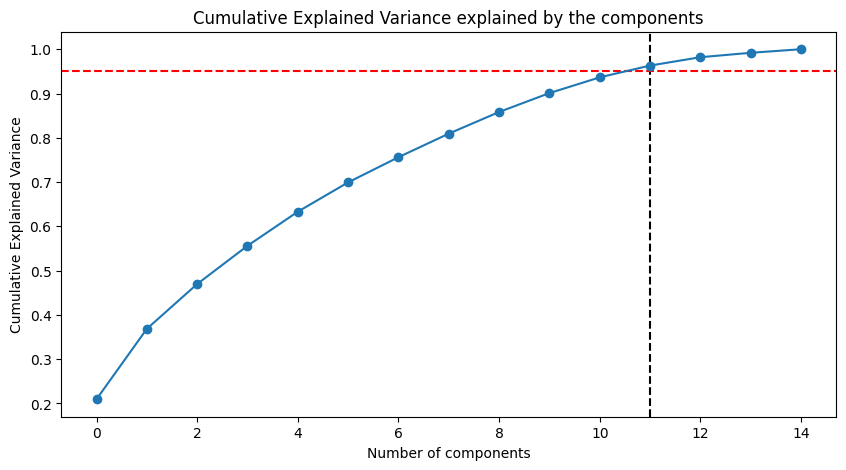

In [115]:
plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of components')
plt.axvline(x=components_number, color="k", linestyle="--")
plt.axhline(y=threshold, color="r", linestyle="--")
plt.plot(cumulative_var, marker='o')
plt.show()

Based on the Principal Components Analysis we can conclude that statistically, we would get should get quite good reluts if we only take 11 features into consideration. 

However, since this dataset is already trimmed by a lot by using hypothesis testing, I will keep all the features when creating our model (or rather concoction of three models) and later decide if it could be trimmed further with feature importances. 

Now with the data splitted into train and test subsets, we can move onto the modeling!

## Model creation

In [116]:
# firstly let's create some useful functions

def calculate_metrics(target, prediction, average='macro'):
    '''
    With this function we generate all metrics we want to check for classification problem
    '''
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average, zero_division = 0)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    roc = roc_auc_score(target, prediction)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, roc, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    '''
    With this function we are printing all the metrics
    '''
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  ROC score: {metrics[4]}')
    print(f'  Mislabeled {metrics[5]} out of {metrics[6]}')
    
    
def get_binary_classes(y):
    '''
    With this function we print out the original proporions of 0 and 1 in the subset
    '''
    zeros = len([x for x in y if x == 0])
    ones = len([x for x in y if x == 1])
    print(f'Quantities are {zeros} for 0, {ones} for 1')
    print('\n')
    
def get_confusion_matrix(y, y_pred):
    '''
    This function returns a visualization of a confusion matrix
    '''
    fig, ax = plt.subplots(figsize=(3,3))
    cm = confusion_matrix(y, y_pred)
    ax = sns.heatmap(cm, annot = True, fmt = 'd')
    plt.show()

In [ ]:
y = df.pop('Mortality')
X = df

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=27,
                                                   stratify=y 
                                                   )

# to balance out the data, let's use SMOTE
sm = SMOTE(random_state=42,
           sampling_strategy='auto',
           k_neighbors=4 
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

Results for 1
----
  Accuracy:  0.8536585365853658
  Precision: 0.857487922705314
  Recall:    0.8523809523809525
  F1 score:  0.8528708133971292
  ROC score: 0.8523809523809524
  Mislabeled 6 out of 41
Quantities are 20 for 0, 21 for 1




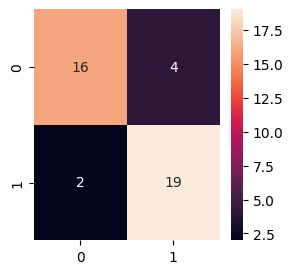

Results for 2
----
  Accuracy:  0.8536585365853658
  Precision: 0.8705128205128205
  Recall:    0.8456937799043063
  F1 score:  0.8492647058823529
  ROC score: 0.8456937799043063
  Mislabeled 6 out of 41
Quantities are 19 for 0, 22 for 1




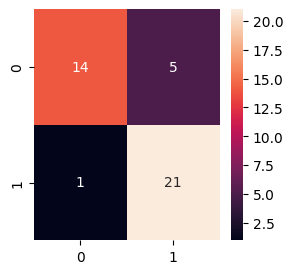

Results for 3
----
  Accuracy:  0.875
  Precision: 0.875
  Recall:    0.8759398496240601
  F1 score:  0.8749218261413383
  ROC score: 0.8759398496240601
  Mislabeled 5 out of 40
Quantities are 19 for 0, 21 for 1




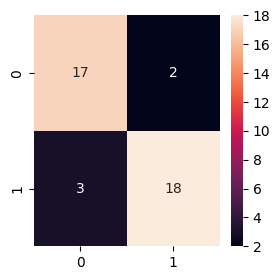

Results for 4
----
  Accuracy:  0.825
  Precision: 0.8333333333333334
  Recall:    0.8156565656565656
  F1 score:  0.819471308833011
  ROC score: 0.8156565656565657
  Mislabeled 7 out of 40
Quantities are 22 for 0, 18 for 1




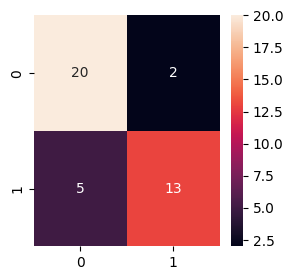

Results for 5
----
  Accuracy:  0.8
  Precision: 0.80306905370844
  Recall:    0.7969924812030075
  F1 score:  0.797979797979798
  ROC score: 0.7969924812030076
  Mislabeled 8 out of 40
Quantities are 21 for 0, 19 for 1




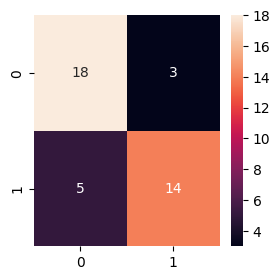

In [133]:
kfoldcv = KFold(n_splits=5,
                shuffle=True,
                random_state=27
               )

# let's try on vanilla AdaBoost
for n, (train, val) in enumerate(kfoldcv.split(X_train_sm, y_train_sm), 1):
    X_train_fold, y_train_fold = X_train_sm.iloc[train], y_train_sm.iloc[train]
    X_val_fold, y_val_fold = X_train_sm.iloc[val], y_train_sm.iloc[val]
    
    # X_train_scaled = scaler.fit_transform(X_train_fold)
    # X_val_scaled = scaler.fit_transform(X_val_fold)
    
    ada1 = AdaBoostClassifier()
    ada1.fit(X_train_fold, y_train_fold)
    y_pred = ada1.predict(X_val_fold)
    
    print_results(calculate_metrics(y_val_fold, y_pred), classifier_id=n)
    get_binary_classes(y_val_fold)
    get_confusion_matrix(y_val_fold, y_pred)

Results for classifier
----
  Accuracy:  0.8387096774193549
  Precision: 0.71
  Recall:    0.7423076923076923
  F1 score:  0.7237076648841355
  ROC score: 0.7423076923076923
  Mislabeled 5 out of 31
Quantities are 26 for 0, 5 for 1




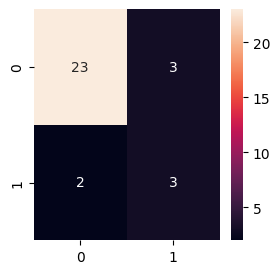

In [134]:
# let's test it on test data, which the model has not seen before
# X_test_scaled = scaler.fit_transform(X_test)
y_test_pred = ada1.predict(X_test)

print_results(calculate_metrics(y_test, y_test_pred))
get_binary_classes(y_test)
get_confusion_matrix(y_test, y_test_pred)

I do use quite a lot of metrics here, however the ones that interest me the most are **ROC score**, **F1 score** and **Accuracy**. I am also analyzing the confusion matrices, to know where the mistakes are generated most often. 

This vanilla `AdaBoostClassifier` did quite a good job actually, better than I expected. Also, taking into consideration the results cross validation, it seems that the predictions in all cases are not random. This initial model's biggest problem is predicting false nevatives to often, which in out case is the worst scenario, as it indicates that a patient should live, but they die instead. Also, probably due to the duplicates, the test result might be due to overfitting.

Now, let's use `OPTUNA`, to see if we can get a better scores with AdaBoost.

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=27,
                                                   stratify=y 
                                                   )
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27,
           sampling_strategy='auto',
           k_neighbors=4 # choosing the amount od neighbours, 5 is default
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train_sm, y_train_sm,
                                                      test_size=0.25,
                                                      random_state=27,
                                                      stratify=y_train_sm
                                                     )

def objective(trial):
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_val_scaled = scaler.fit_transform(X_val)
    

    n_estimators = trial.suggest_int('n_estimators', 100,1000)
    learning_rate = trial.suggest_float('learning_rate', 0.001,10)
 

    ada2 = AdaBoostClassifier(
                               n_estimators=n_estimators,
                               learning_rate=learning_rate
                              )

    ada2.fit(X_train, y_train)
    y_pred_val = ada2.predict(X_val)
    roc = roc_auc_score(y_val, y_pred_val)
    return roc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[I 2023-10-05 23:54:49,011] A new study created in memory with name: no-name-a0f02867-1fbf-4f82-8c2f-ff360a654f79
[I 2023-10-05 23:54:49,211] Trial 0 finished with value: 0.7461538461538462 and parameters: {'n_estimators': 244, 'learning_rate': 7.815663600709515}. Best is trial 0 with value: 0.7461538461538462.
[I 2023-10-05 23:54:49,763] Trial 1 finished with value: 0.6653846153846155 and parameters: {'n_estimators': 709, 'learning_rate': 3.413578535009256}. Best is trial 0 with value: 0.7461538461538462.
[I 2023-10-05 23:54:50,111] Trial 2 finished with value: 0.7461538461538462 and parameters: {'n_estimators': 430, 'learning_rate': 2.250347630711575}. Best is trial 0 with value: 0.7461538461538462.
[I 2023-10-05 23:54:50,304] Trial 3 finished with value: 0.8607692307692308 and parameters: {'n_estimators': 219, 'learning_rate': 1.5141302128058782}. Best is trial 3 with value: 0.8607692307692308.
[I 2023-10-05 23:54:50,478] Trial 4 finished with value: 0.7461538461538462 and parameter

In [136]:
best_params = study.best_params
best_params

{'n_estimators': 100, 'learning_rate': 0.20419560176452034}

Results for 1
----
  Accuracy:  0.8536585365853658
  Precision: 0.857487922705314
  Recall:    0.8523809523809525
  F1 score:  0.8528708133971292
  ROC score: 0.8523809523809524
  Mislabeled 6 out of 41
Quantities are 20 for 0, 21 for 1




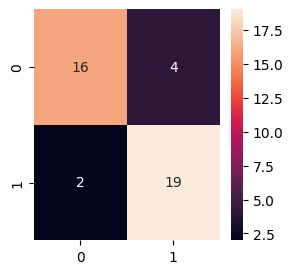

Results for 2
----
  Accuracy:  0.9024390243902439
  Precision: 0.8983253588516746
  Recall:    0.9080882352941176
  F1 score:  0.9009661835748792
  ROC score: 0.9080882352941176
  Mislabeled 4 out of 41
Quantities are 17 for 0, 24 for 1




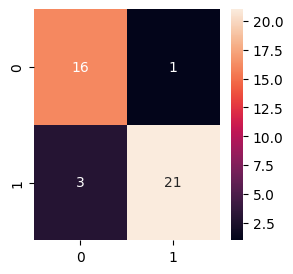

Results for 3
----
  Accuracy:  0.975
  Precision: 0.9772727272727273
  Recall:    0.9736842105263157
  F1 score:  0.9748585795097424
  ROC score: 0.9736842105263158
  Mislabeled 1 out of 40
Quantities are 19 for 0, 21 for 1




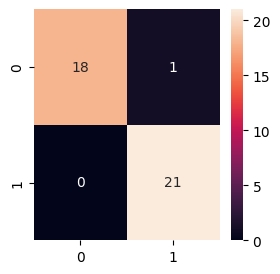

Results for 4
----
  Accuracy:  0.875
  Precision: 0.8784461152882206
  Recall:    0.8813131313131313
  F1 score:  0.8749218261413383
  ROC score: 0.8813131313131313
  Mislabeled 5 out of 40
Quantities are 22 for 0, 18 for 1




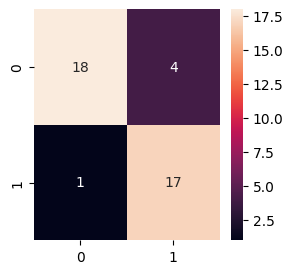

Results for 5
----
  Accuracy:  0.875
  Precision: 0.875
  Recall:    0.8682864450127876
  F1 score:  0.871050934880722
  ROC score: 0.8682864450127877
  Mislabeled 5 out of 40
Quantities are 23 for 0, 17 for 1




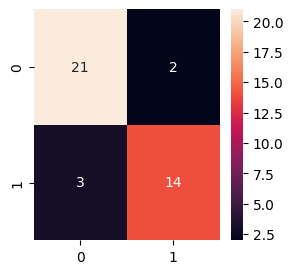

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y 
                                                   )
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42,
           sampling_strategy='auto',
           k_neighbors=4 # choosing the amount od neighbours, 5 is default
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

for n, (train, val) in enumerate(kfoldcv.split(X_train_sm, y_train_sm), 1):
    X_train_fold, y_train_fold = X_train_sm.iloc[train], y_train_sm.iloc[train]
    X_val_fold, y_val_fold = X_train_sm.iloc[val], y_train_sm.iloc[val]
    
    # X_train_scaled = scaler.fit_transform(X_train_fold)
    # X_val_scaled = scaler.fit_transform(X_val_fold)
    
    best_params = study.best_params
    ada2 = AdaBoostClassifier(
                         n_estimators=best_params['n_estimators'],
                         learning_rate=best_params['learning_rate']
                              )    
                              
    ada2.fit(X_train_fold, y_train_fold)
    y_pred = ada2.predict(X_val_fold)
    
    print_results(calculate_metrics(y_val_fold, y_pred), classifier_id=n)
    get_binary_classes(y_val_fold)
    get_confusion_matrix(y_val_fold, y_pred)

Upon checking, it seems this time `OPTUNA` failed to find a better hyperparameters and the vanilla model works the best, which can we shown in cross validation above.

Results for classifier
----
  Accuracy:  0.8387096774193549
  Precision: 0.71
  Recall:    0.7423076923076923
  F1 score:  0.7237076648841355
  ROC score: 0.7423076923076923
  Mislabeled 5 out of 31
Quantities are 26 for 0, 5 for 1




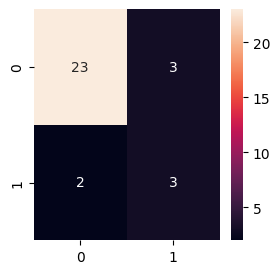

In [138]:
# let's test it on test data, which the model has not seen before
# X_test_scaled = scaler.fit_transform(X_test)
y_test_pred = ada2.predict(X_test)

print_results(calculate_metrics(y_test, y_test_pred))
get_binary_classes(y_test)
get_confusion_matrix(y_test, y_test_pred)

In [139]:
feat_importance_ada = ada2.feature_importances_

# Creating feature importance df
feat_importance_ada_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feat_importance_ada})
feat_importance_ada_df = feat_importance_ada_df.sort_values(by='Importance', ascending=False)

print("AdaBoost Feature Importance:")
print(feat_importance_ada_df)

AdaBoost Feature Importance:
     Feature  Importance
6        Age        0.26
4     Others        0.13
10   oldpeak        0.09
12  Reaction        0.09
2    Smoking        0.08
11        ca        0.08
0   AgeGroup        0.07
9        WBC        0.07
1     Gender        0.06
13  FollowUp        0.06
5    SKReact        0.01
3        HTN        0.00
7   FHistory        0.00
8   Diabetes        0.00


Adaboost did well, but I want to try XGBoost as well.

Results for 1
----
  Accuracy:  0.9024390243902439
  Precision: 0.9070048309178744
  Recall:    0.9011904761904761
  F1 score:  0.901913875598086
  ROC score: 0.9011904761904761
  Mislabeled 4 out of 41
Quantities are 20 for 0, 21 for 1




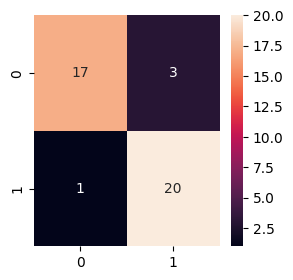

Results for 2
----
  Accuracy:  0.8048780487804879
  Precision: 0.8666666666666667
  Recall:    0.7894736842105263
  F1 score:  0.7897435897435897
  ROC score: 0.7894736842105263
  Mislabeled 8 out of 41
Quantities are 19 for 0, 22 for 1




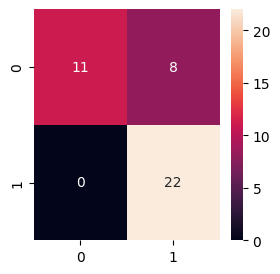

Results for 3
----
  Accuracy:  0.975
  Precision: 0.9772727272727273
  Recall:    0.9736842105263157
  F1 score:  0.9748585795097424
  ROC score: 0.9736842105263158
  Mislabeled 1 out of 40
Quantities are 19 for 0, 21 for 1




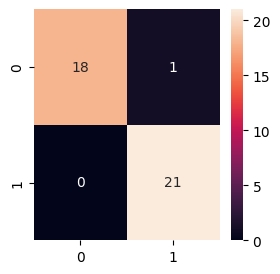

Results for 4
----
  Accuracy:  0.9
  Precision: 0.8999999999999999
  Recall:    0.904040404040404
  F1 score:  0.899749373433584
  ROC score: 0.904040404040404
  Mislabeled 4 out of 40
Quantities are 22 for 0, 18 for 1




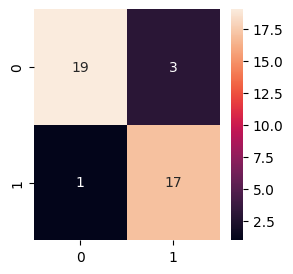

Results for 5
----
  Accuracy:  0.9
  Precision: 0.9053708439897699
  Recall:    0.8972431077694235
  F1 score:  0.8989898989898989
  ROC score: 0.8972431077694235
  Mislabeled 4 out of 40
Quantities are 21 for 0, 19 for 1




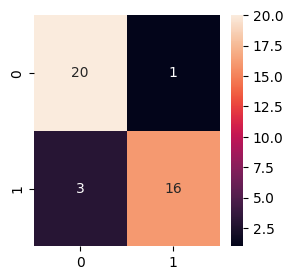

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=27,
                                                   stratify=y 
                                                   )
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27,
           sampling_strategy='auto',
           k_neighbors=4 # choosing the amount od neighbours, 5 is default
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# let's try on vanilla AdaBoost
for n, (train, val) in enumerate(kfoldcv.split(X_train_sm, y_train_sm), 1):
    X_train_fold, y_train_fold = X_train_sm.iloc[train], y_train_sm.iloc[train]
    X_val_fold, y_val_fold = X_train_sm.iloc[val], y_train_sm.iloc[val]
    
    # X_train_scaled = scaler.fit_transform(X_train_fold)
    # X_val_scaled = scaler.fit_transform(X_val_fold)
    
    xgb = XGBClassifier()
    xgb.fit(X_train_fold, y_train_fold)
    y_pred = xgb.predict(X_val_fold)
    
    print_results(calculate_metrics(y_val_fold, y_pred), classifier_id=n)
    get_binary_classes(y_val_fold)
    get_confusion_matrix(y_val_fold, y_pred)

Results for classifier
----
  Accuracy:  0.8387096774193549
  Precision: 0.71
  Recall:    0.7423076923076923
  F1 score:  0.7237076648841355
  ROC score: 0.7423076923076923
  Mislabeled 5 out of 31
Quantities are 26 for 0, 5 for 1




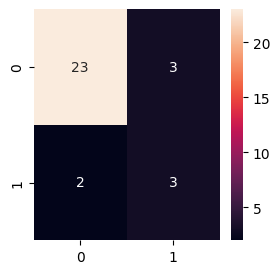

In [141]:
# let's test it on test data, which the model has not seen before
# X_test_scaled = scaler.fit_transform(X_test)
y_test_pred = xgb.predict(X_test)

print_results(calculate_metrics(y_test, y_test_pred))
get_binary_classes(y_test)
get_confusion_matrix(y_test, y_test_pred)

Vanilla XGBoost did better on the unseen data than AdaBoost. 
So let's try with Optuna!

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=27,
                                                   stratify=y 
                                                   )
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27,
           sampling_strategy='auto',
           k_neighbors=4 # choosing the amount od neighbours, 5 is default
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train_sm, y_train_sm,
                                                      test_size=0.25,
                                                      random_state=27,
                                                      stratify=y_train_sm
                                                     )

def objective(trial):

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-5, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-5, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0)
    }


    xgb2 = XGBClassifier(**params, random_state=42)

    xgb2.fit(X_train, y_train)
    y_pred_val = xgb2.predict(X_val)
    roc = roc_auc_score(y_val, y_pred_val)
    return roc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[I 2023-10-05 23:56:11,218] A new study created in memory with name: no-name-8ed40070-3941-4037-9b05-928d9debdc34
[I 2023-10-05 23:56:11,427] Trial 0 finished with value: 0.84 and parameters: {'booster': 'dart', 'lambda': 2.0763103869306296, 'alpha': 0.007709991345527624, 'max_depth': 7, 'eta': 0.23216659611466264, 'gamma': 0.6607889153296604, 'subsample': 0.87699607230817, 'colsample_bytree': 0.37567875897596814}. Best is trial 0 with value: 0.84.
[I 2023-10-05 23:56:11,447] Trial 1 finished with value: 0.6269230769230769 and parameters: {'booster': 'gblinear', 'lambda': 0.00016039266969861482, 'alpha': 1.5788452607740866, 'max_depth': 16, 'eta': 0.22153652904014848, 'gamma': 0.7600264666368561, 'subsample': 0.190155706660145, 'colsample_bytree': 0.19856652703792516}. Best is trial 0 with value: 0.84.
[I 2023-10-05 23:56:11,468] Trial 2 finished with value: 0.6469230769230768 and parameters: {'booster': 'gblinear', 'lambda': 6.499127463489234, 'alpha': 0.000548924043224585, 'max_depth

[23:56:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.

[23:56:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.

[23:56:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.



[I 2023-10-05 23:56:11,810] Trial 7 finished with value: 0.84 and parameters: {'booster': 'dart', 'lambda': 3.623442744936379e-05, 'alpha': 1.7526056777617736, 'max_depth': 12, 'eta': 0.09717445557615934, 'gamma': 0.5179077338466279, 'subsample': 0.8150097709807066, 'colsample_bytree': 0.4161948816508774}. Best is trial 4 with value: 0.8607692307692308.
[I 2023-10-05 23:56:12,069] Trial 8 finished with value: 0.86 and parameters: {'booster': 'dart', 'lambda': 0.07845032669995083, 'alpha': 0.006806173808654247, 'max_depth': 3, 'eta': 0.0795269630568306, 'gamma': 0.5190557407287203, 'subsample': 0.5541766741768259, 'colsample_bytree': 0.6882829831676928}. Best is trial 4 with value: 0.8607692307692308.
[I 2023-10-05 23:56:12,095] Trial 9 finished with value: 0.8023076923076923 and parameters: {'booster': 'gblinear', 'lambda': 0.00031714185138130574, 'alpha': 0.0374373595479859, 'max_depth': 13, 'eta': 0.2559635755827649, 'gamma': 0.14545861809021765, 'subsample': 0.3482099987933825, 'col

[23:56:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.



[I 2023-10-05 23:56:12,292] Trial 11 finished with value: 0.86 and parameters: {'booster': 'gbtree', 'lambda': 0.0029247306421860994, 'alpha': 0.3037848458692136, 'max_depth': 19, 'eta': 0.2689825222499968, 'gamma': 0.8708552874860142, 'subsample': 0.37667146472607305, 'colsample_bytree': 0.7771942273988917}. Best is trial 4 with value: 0.8607692307692308.
[I 2023-10-05 23:56:12,367] Trial 12 finished with value: 0.84 and parameters: {'booster': 'gbtree', 'lambda': 0.003135315047196213, 'alpha': 7.797185154917421, 'max_depth': 17, 'eta': 0.2957263037706554, 'gamma': 0.810053613184279, 'subsample': 0.6623763957342785, 'colsample_bytree': 0.5788086797610759}. Best is trial 4 with value: 0.8607692307692308.
[I 2023-10-05 23:56:12,446] Trial 13 finished with value: 0.8415384615384616 and parameters: {'booster': 'gbtree', 'lambda': 0.02294715910659859, 'alpha': 0.14937438684501037, 'max_depth': 9, 'eta': 0.1903048415473913, 'gamma': 0.6768290071905535, 'subsample': 0.10733371397469949, 'col

[23:56:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.



[I 2023-10-05 23:56:14,864] Trial 30 finished with value: 0.84 and parameters: {'booster': 'dart', 'lambda': 0.00021334304368181563, 'alpha': 3.410150783014721, 'max_depth': 7, 'eta': 0.1724999327329158, 'gamma': 0.8291301626189493, 'subsample': 0.4511939882520771, 'colsample_bytree': 0.9059674738758501}. Best is trial 16 with value: 0.88.
[I 2023-10-05 23:56:14,954] Trial 31 finished with value: 0.86 and parameters: {'booster': 'gbtree', 'lambda': 2.575410567455203e-05, 'alpha': 0.6974199552996626, 'max_depth': 4, 'eta': 0.138387734178379, 'gamma': 0.9101103551663042, 'subsample': 0.546596236380197, 'colsample_bytree': 0.8222442043868124}. Best is trial 16 with value: 0.88.
[I 2023-10-05 23:56:15,060] Trial 32 finished with value: 0.86 and parameters: {'booster': 'gbtree', 'lambda': 0.00010945275278195096, 'alpha': 1.1847046778337087, 'max_depth': 6, 'eta': 0.10359483491898647, 'gamma': 0.783997415735589, 'subsample': 0.6388942199798786, 'colsample_bytree': 0.9339460339907764}. Best i

[23:56:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.

[23:56:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.



[I 2023-10-05 23:56:15,606] Trial 38 finished with value: 0.86 and parameters: {'booster': 'gbtree', 'lambda': 2.114619275345866e-05, 'alpha': 0.24372351316447305, 'max_depth': 7, 'eta': 0.11317241023068424, 'gamma': 0.8446664903139405, 'subsample': 0.43126051705528573, 'colsample_bytree': 0.9885288173313097}. Best is trial 16 with value: 0.88.
[I 2023-10-05 23:56:15,713] Trial 39 finished with value: 0.86 and parameters: {'booster': 'gbtree', 'lambda': 0.00014391863695442764, 'alpha': 0.03430127300480199, 'max_depth': 4, 'eta': 0.13512034641150125, 'gamma': 0.9325427279839642, 'subsample': 0.5169950048394404, 'colsample_bytree': 0.8647738630792947}. Best is trial 16 with value: 0.88.


Results for 1
----
  Accuracy:  0.9024390243902439
  Precision: 0.9070048309178744
  Recall:    0.9011904761904761
  F1 score:  0.901913875598086
  ROC score: 0.9011904761904761
  Mislabeled 4 out of 41
Quantities are 20 for 0, 21 for 1




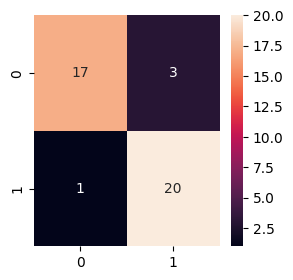

Results for 2
----
  Accuracy:  0.8048780487804879
  Precision: 0.8666666666666667
  Recall:    0.7894736842105263
  F1 score:  0.7897435897435897
  ROC score: 0.7894736842105263
  Mislabeled 8 out of 41
Quantities are 19 for 0, 22 for 1




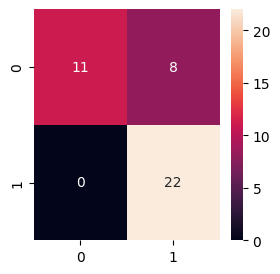

Results for 3
----
  Accuracy:  0.975
  Precision: 0.9772727272727273
  Recall:    0.9736842105263157
  F1 score:  0.9748585795097424
  ROC score: 0.9736842105263158
  Mislabeled 1 out of 40
Quantities are 19 for 0, 21 for 1




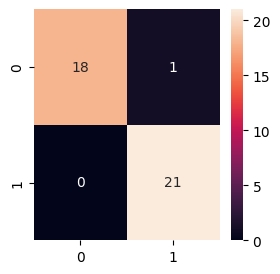

Results for 4
----
  Accuracy:  0.875
  Precision: 0.8784461152882206
  Recall:    0.8813131313131313
  F1 score:  0.8749218261413383
  ROC score: 0.8813131313131313
  Mislabeled 5 out of 40
Quantities are 22 for 0, 18 for 1




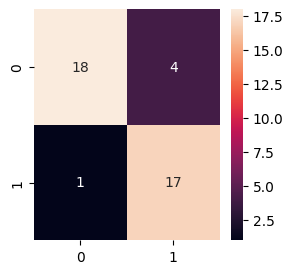

Results for 5
----
  Accuracy:  0.875
  Precision: 0.875
  Recall:    0.8759398496240601
  F1 score:  0.8749218261413383
  ROC score: 0.8759398496240602
  Mislabeled 5 out of 40
Quantities are 21 for 0, 19 for 1




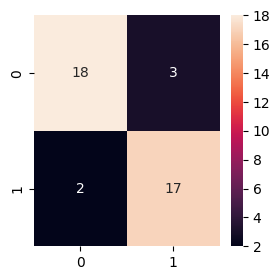

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=27,
                                                   stratify=y 
                                                   )
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27,
           sampling_strategy='auto',
           k_neighbors=4 # choosing the amount od neighbours, 5 is default
          )

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

for n, (train, val) in enumerate(kfoldcv.split(X_train_sm, y_train_sm), 1):
    X_train_fold, y_train_fold = X_train_sm.iloc[train], y_train_sm.iloc[train]
    X_val_fold, y_val_fold = X_train_sm.iloc[val], y_train_sm.iloc[val]
    
    best_params = study.best_params


    xgb = XGBClassifier(
        booster=best_params['booster'],
        alpha=best_params['alpha'],
        max_depth=best_params['max_depth'],
        eta=best_params['eta'],
        gamma=best_params['gamma'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    )


    xgb.fit(X_train_fold, y_train_fold)
    y_pred = xgb.predict(X_val_fold)
    
    print_results(calculate_metrics(y_val_fold, y_pred), classifier_id=n)
    get_binary_classes(y_val_fold)
    get_confusion_matrix(y_val_fold, y_pred)

Results for classifier
----
  Accuracy:  0.8709677419354839
  Precision: 0.7615384615384615
  Recall:    0.7615384615384615
  F1 score:  0.7615384615384615
  ROC score: 0.7615384615384616
  Mislabeled 4 out of 31
Quantities are 26 for 0, 5 for 1




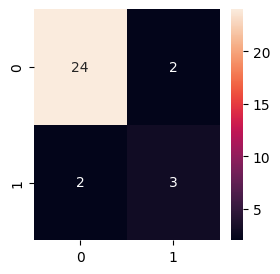

In [145]:
# let's test it on test data, which the model has not seen before
# X_test_scaled = scaler.fit_transform(X_test)
y_test_pred = xgb.predict(X_test)

print_results(calculate_metrics(y_test, y_test_pred))
get_binary_classes(y_test)
get_confusion_matrix(y_test, y_test_pred)

In [146]:
feat_importance_xgb = xgb.feature_importances_

# Tworzenie DataFrame z ważnością cech
feat_importance_xgb_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feat_importance_xgb})
feat_importance_xgb_df = feat_importance_xgb_df.sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance:")
print(feat_importance_xgb_df)

XGBoost Feature Importance:
     Feature  Importance
12  Reaction    0.226614
0   AgeGroup    0.132141
7   FHistory    0.089735
8   Diabetes    0.083282
6        Age    0.066851
1     Gender    0.066045
11        ca    0.060311
2    Smoking    0.056663
13  FollowUp    0.054378
10   oldpeak    0.047214
5    SKReact    0.042033
9        WBC    0.037593
4     Others    0.037142
3        HTN    0.000000


In [147]:
with open('data/model.pkl', 'wb') as f:
    pickle.dump((xgb), f)